# Exploratory Data Analysis

The goal of this project is to develop recommendation systems for the Food.com dataset (Li et al. 2019) available on Kaggle. The aim of this EDA is to determine which features will be useful for understanding user preferences, learn about the characteristics of the dataset, identify insights and peculiarities, and help me start thinking about feature engineering.

### Load Data

#### Import Libraries

In [42]:
from pyspark.sql import SparkSession

import ast
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Define data location
RAW_DATA_PATH = r"..\data\raw"
RECIPES_FILE = "RAW_recipes.csv"
INTERACTIONS_FILE = "RAW_interactions.csv"

recipes_path = os.path.join(RAW_DATA_PATH, RECIPES_FILE)
interactions_path = os.path.join(RAW_DATA_PATH, INTERACTIONS_FILE)

In [0]:
# Initial data import
recipes = pd.read_csv(recipes_path)
interactions = pd.read_csv(interactions_path)

#### Inspect initial format

In [4]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [3]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


#### Basic transforms
From the above, I can identify a few simple transforms that will assist in EDA. Date formats will allow plotting trends, and there are a number of columns that contain lists of values, which can be stored in the DataFrame. Finally, the removal of newlines in text fields will help with future NLP tasks and parsing if the data is later exported or converted


In [7]:
# Convert dates
recipes["submitted"] = pd.to_datetime(recipes["submitted"], format="%Y-%m-%d")
interactions["date"] = pd.to_datetime(interactions["date"], format="%Y-%m-%d")

# Remove special characters from 
recipes["description"] = recipes["description"].str.replace("\r\n", " ")
interactions["review"] = interactions["review"].str.replace("\r\n", " ")

# Cast list-like columns explicitly into lists
list_like_columns = ["tags", "nutrition", "steps", "ingredients"]
recipes[list_like_columns] = recipes[list_like_columns].applymap(ast.literal_eval)

# Separate values in the nutrition column into their own columns
nutrition_cols = ["calories", "total_fat_pdv", "sugar_pdv", "sodium_pdv", "protein_pdv", "saturated_fat_pdv", "carbohydrates_pdv"]
recipes[nutrition_cols] = pd.DataFrame(recipes["nutrition"].tolist(), index=recipes.index)
recipes.drop("nutrition", inplace=True, axis=1)

In [8]:
# Check the new schemas and count null values
recipes.info()
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   name               231636 non-null  object        
 1   id                 231637 non-null  int64         
 2   minutes            231637 non-null  int64         
 3   contributor_id     231637 non-null  int64         
 4   submitted          231637 non-null  datetime64[ns]
 5   tags               231637 non-null  object        
 6   n_steps            231637 non-null  int64         
 7   steps              231637 non-null  object        
 8   description        226658 non-null  object        
 9   ingredients        231637 non-null  object        
 10  n_ingredients      231637 non-null  int64         
 11  calories           231637 non-null  float64       
 12  total_fat_pdv      231637 non-null  float64       
 13  sugar_pdv          231637 non-null  float64 

### Analysis
#### Descriptive stats for numeric values

In [12]:
recipes[["minutes", "submitted", "n_steps", "n_ingredients", "calories", "total_fat_pdv", "sugar_pdv", "sodium_pdv", "protein_pdv", "saturated_fat_pdv", "carbohydrates_pdv"]].describe()

,minutes,submitted,n_steps,n_ingredients,calories,total_fat_pdv,sugar_pdv,sodium_pdv,protein_pdv,saturated_fat_pdv,carbohydrates_pdv
count,2.316370e+05,231637,231637.000000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000
mean,9.398546e+03,2006-11-14 01:58:34.925508096,9.765499,9.051153,473.942425,36.08070,84.296865,30.147485,34.68186,45.589150,15.560403
min,0.000000e+00,1999-08-06 00:00:00,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,2.000000e+01,2004-09-16 00:00:00,6.000000,6.000000,174.400000,8.00000,9.000000,5.000000,7.00000,7.000000,4.000000
50%,4.000000e+01,2007-01-23 00:00:00,9.000000,9.000000,313.400000,20.00000,25.000000,14.000000,18.00000,23.000000,9.000000
75%,6.500000e+01,2008-10-29 00:00:00,12.000000,11.000000,519.700000,41.00000,68.000000,33.000000,51.00000,52.000000,16.000000
max,2.147484e+09,2018-12-04 00:00:00,145.000000,43.000000,434360.200000,17183.00000,362729.000000,29338.000000,6552.00000,10395.000000,36098.000000
std,4.461963e+06,NaN,5.995128,3.734796,1189.711374,77.79884,800.080897,131.961589,58.47248,98.235758,81.824560


In [14]:
interactions[["date","rating"]].describe()

,date,rating
count,1132367,1.132367e+06
mean,2009-05-13 02:57:38.777586944,4.411016e+00
min,2000-01-25 00:00:00,0.000000e+00
25%,2007-03-11 00:00:00,4.000000e+00
50%,2008-12-29 00:00:00,5.000000e+00
75%,2011-03-07 00:00:00,5.000000e+00
max,2018-12-20 00:00:00,5.000000e+00
std,NaN,1.264752e+00


#### Examine outliers

In [40]:
outlier_fields = ["minutes", "calories", "total_fat_pdv", "sugar_pdv", "sodium_pdv", "protein_pdv", "saturated_fat_pdv", "carbohydrates_pdv"]
# thresholds = [60 * 24, 2000, 100, 100, 100, 100, 100, 100]
for field in outlier_fields:
    print(f"Top values for {field}:")
    print(recipes[field].nlargest(10),"\n")

Top values for minutes:
109624    1051200
106563     288000
38116      259260
106963     259205
155044     216015
5497       201610
177906     187200
170999     172810
53721      172800
102299     167040
Name: minutes, dtype: int64 

Top values for calories:
209453    434360.2
70467     101614.7
165504     45609.0
137181     44239.8
34023      43924.6
141997     42951.6
78689      40159.2
182816     38680.1
199615     38662.3
139058     36188.8
Name: calories, dtype: float64 

Top values for total_fat_pdv:
70467     17183.0
199615     4331.0
182816     4317.0
56433      3464.0
165504     3379.0
84023      3229.0
164719     3105.0
102405     3072.0
134453     3021.0
219494     2899.0
Name: total_fat_pdv, dtype: float64 

Top values for sugar_pdv:
209453    362729.0
139058     30260.0
34023      18943.0
107018     18127.0
137181     17306.0
165504     16901.0
95612      14495.0
105817     13573.0
931        12914.0
187719     11042.0
Name: sugar_pdv, dtype: float64 

Top values for sodiu

A few quick takeaways:
* The minutes field and nutritional fields have significant outliers that skew the mean
    * Upon inspection of these recipes pages, the nutrition values are mostly from large bulk specialty recipes (e.g., brewing large quantities of whiskey) 
    * The minutes field seem to be errors or jokes, but the top value (2^31 minutes/4000 years) seems to be a mistake, and the next value is (288000 minutes/6 months) which is much left of an outlier. 
* The data seems nicely distributed over time; user interactions trail recipes submissions as expected
* Ratings distribution is skewed in a typical manner

In [38]:
# Correct minutes outlier
recipes.at[144074, "minutes"] = 25

#### Basic Univariate Distributions

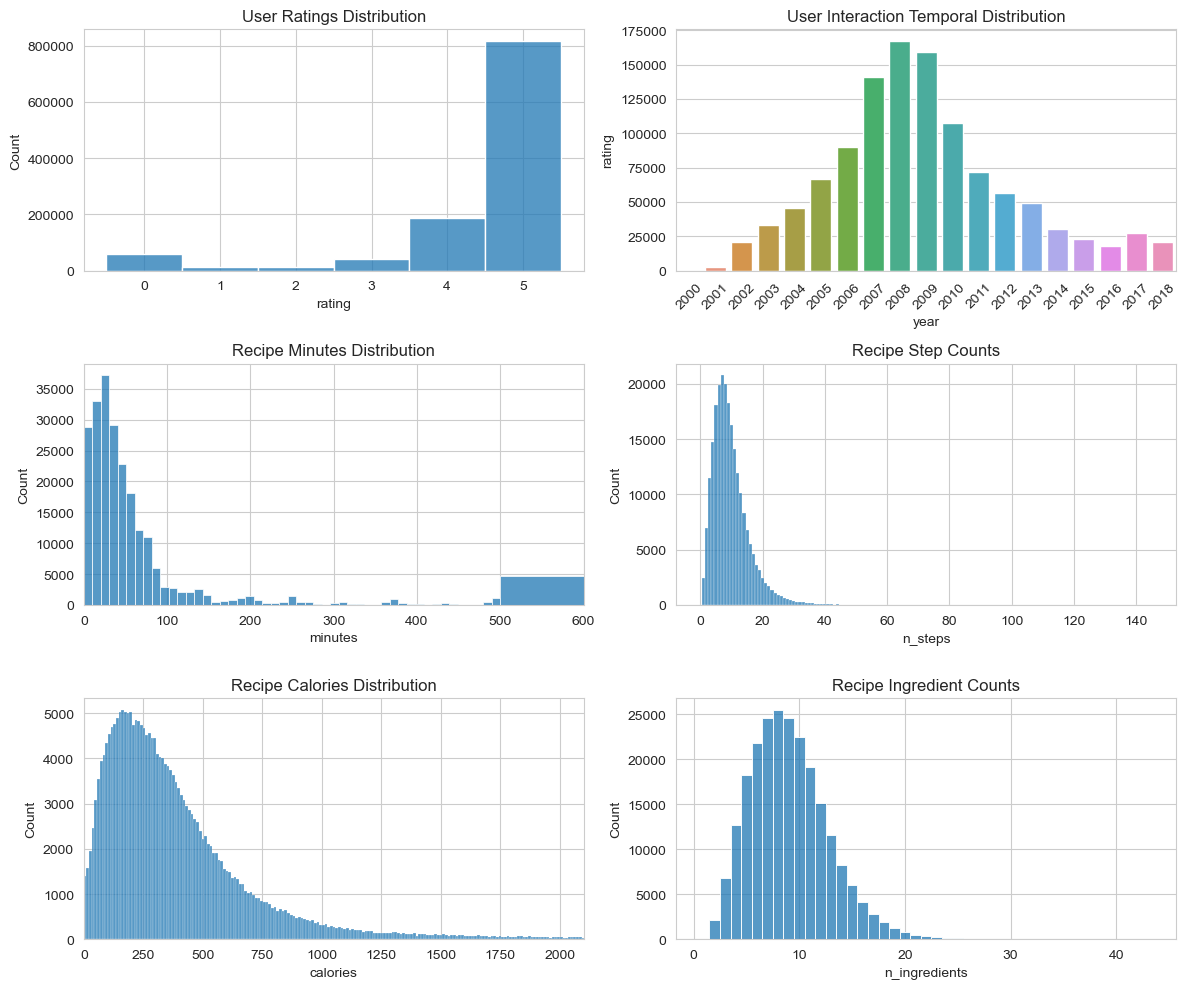

In [67]:
sns.set_style('whitegrid')

plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.title("User Ratings Distribution")
sns.histplot(interactions["rating"], discrete=True)

plt.subplot(3, 2, 2)
plt.title("User Interaction Temporal Distribution")
dates = interactions[['date','rating']].set_index('date')
date_counts = dates.resample('Y').count()
date_counts.reset_index(inplace=True)
date_counts['year'] = date_counts['date'].dt.strftime('%Y')
sns.barplot(x=date_counts['year'], y=date_counts['rating'])
plt.xticks(rotation=45) 

plt.subplot(3, 2, 3)
plt.title("Recipe Minutes Distribution")
edges = np.linspace(recipes.minutes.min(), 500, 50)
edges = np.append(edges, recipes.minutes.max())
plt.xlim([0,600])
sns.histplot(recipes["minutes"], bins=edges)

plt.subplot(3, 2, 4)
plt.title("Recipe Step Counts")
sns.histplot(recipes["n_steps"], discrete=True)

plt.subplot(3, 2, 5)
plt.title("Recipe Calories Distribution")
edges = np.linspace(recipes.calories.min(), 2000, 50)
edges = np.append(edges, recipes.calories.max())
plt.xlim([0,2100])
sns.histplot(recipes["calories"])

plt.subplot(3, 2, 6)
plt.title("Recipe Ingredient Counts")
sns.histplot(recipes["n_ingredients"], discrete=True)

plt.tight_layout()
plt.show()